In [1]:
!pip install plotly==4.12.0
!pip install statsmodels==0.12.2
!pip install pymc3==3.11.4
!pip install kaleido==0.2.1

     |████████████████████████████████| 13.1 MB 3.4 MB/s            
  Attempting uninstall: plotly
    Found existing installation: plotly 5.4.0
    Uninstalling plotly-5.4.0:
      Successfully uninstalled plotly-5.4.0


In [2]:
from __future__ import annotations
import pandas as pd
import datetime as dt
import numpy as np
import scipy.stats as st
import requests
import plotly
import plotly.graph_objects as go
import plotly.express as px
import pymc3 as pm
import arviz as az
import theano.tensor as tt
from abc import ABC, abstractmethod
from matplotlib import pyplot as plt
from collections import defaultdict
from typing import List
from plotly.subplots import make_subplots
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import lilliefors
from statsmodels.graphics.gofplots import qqplot

In [24]:
class SerialInterval:
    def __init__(self, dist, name):
        self._dist = dist
        self._name = name

    def get_trace(self):
        xx = np.linspace(0, 20, 1000)
        # fig = go.Figure()
        # fig.add_trace(go.Scatter(x=xx, y=self.dist.pdf(xx)))
        # fig.show()
        return go.Scatter(x=xx, y=self._dist.pdf(xx), name=self._name)

    def as_weights(self, k):
        vec = np.array([self._dist.pdf(s) for s in range(k)])

        # normalize to sum up to 1
        vec /= vec.sum()

        return vec

In [25]:
class BaseFigure(ABC):
    @abstractmethod
    def show(self) -> BaseFigure:
        pass

    @abstractmethod
    def save(self, image_name: str) -> BaseFigure:
        pass

class MatPlotLibFigure(BaseFigure):
    def __init__(self, figure):
        assert isinstance(figure, matplotlib.figure.Figure)
        self._figure = figure

class PlotlyFigure(BaseFigure):
    def __init__(self, figure):
        assert isinstance(figure, go.Figure)
        self._figure = figure

    def show(self) -> BaseFigure:
        self._figure.show()
        return self

    def save(self, image_name: str) -> BaseFigure:
        self._figure.write_image("images/{}.png".format(image_name), engine="kaleido", scale=1.5)
        return self

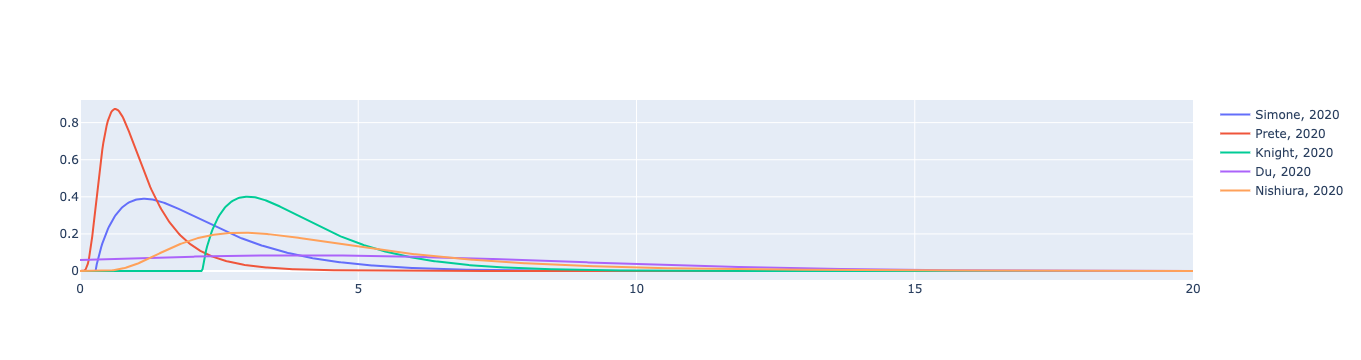

In [26]:
def lognorm_dist(mu, sigma):
    variance = sigma ** 2
    mean_n = np.log(mu) - 0.5*np.log(1 + variance/mu**2)
    variance_n = np.log(variance/mu**2 + 1)

    return st.lognorm(np.sqrt(variance_n), scale=np.exp(mean_n))

simone_si = SerialInterval(st.gamma(1.87, 0.28), "Simone, 2020")
prete_si = SerialInterval(lognorm_dist(1.09, 0.72), "Prete, 2020")
knight_si = SerialInterval(st.gamma(1.813, 2.199), "Knight, 2020")
du_si = SerialInterval(st.norm(3.96, 4.75), "Du, 2020")
nishiura_si = SerialInterval(lognorm_dist(4.7, 2.9), "Nishiura, 2020")

class SerialIntervalsOverviewFigure(PlotlyFigure):
    def __init__(self):
        fig = go.Figure([
            simone_si.get_trace(),
            prete_si.get_trace(),
            knight_si.get_trace(),
            du_si.get_trace(),
            nishiura_si.get_trace()
        ])

        super().__init__(fig)

SerialIntervalsOverviewFigure().save("serial-intervals-overview").show()

In [27]:
tau_m = 15
nishiura_si.as_weights(tau_m)

array([0.        , 0.03615273, 0.16876311, 0.20838187, 0.17767078,
       0.13157696, 0.09180068, 0.06248198, 0.04218485, 0.02849402,
       0.01934185, 0.01322569, 0.00912082, 0.00634708, 0.00445759])

In [28]:
class GeoNode:
    def __init__(self, nuts, name, population, children=[]):
        self.nuts_code = nuts
        self.name = name
        self.population = population
        self.children = children
        self.parent = None

        for child in self.children:
            child.parent = self

    def __repr__(self):
        return "{} ({}) - {}".format(self.name, self.nuts_code, self.population.n_total)

    @property
    def is_leaf(self) -> bool:
        return len(self.children) == 0

    def get_leaves_list(self) -> List[GeoNode]:
        leaves = []

        if self.is_leaf:
            leaves.append(self)
        else:
            for child in self.children:
                leaves.extend(child.get_leaves_list())

        return leaves

class PopulationData:
    def __init__(self, n_males, n_females):
        self.n_males = n_males
        self.n_females = n_females

    @property
    def n_total(self):
        return self.n_males + self.n_females

In [29]:
cz_root_node = GeoNode("CZ0", "Česká republika", PopulationData(5275103, 5426674), [
    GeoNode("CZ01", "Praha", PopulationData(653654, 681430), [
        GeoNode("CZ010", "Hlavní město Praha", PopulationData(653654, 681430), [
            GeoNode("CZ0100", "Praha", PopulationData(653654, 681430))
        ])
    ]),
    GeoNode("CZ02", "Střední Čechy", PopulationData(691986, 706011), [
        GeoNode("CZ020", "Středočeský kraj", PopulationData(691986, 706011), [
            GeoNode("CZ0201", "Benešov", PopulationData(49336, 50406)),
            GeoNode("CZ0202", "Beroun", PopulationData(47682, 48721)),
            GeoNode("CZ0203", "Kladno", PopulationData(81824, 85021)),
            GeoNode("CZ0204", "Kolín", PopulationData(51749, 52183)),
            GeoNode("CZ0205", "Kutná Hora", PopulationData(37888, 38422)),
            GeoNode("CZ0206", "Mělník", PopulationData(54555, 55432)),
            GeoNode("CZ0207", "Mladá Boleslav", PopulationData(66463, 64579)),
            GeoNode("CZ0208", "Nymburk", PopulationData(49872, 51667)),
            GeoNode("CZ0209", "Praha-východ", PopulationData(93450, 95489)),
            GeoNode("CZ020A", "Praha-západ", PopulationData(74616, 77669)),
            GeoNode("CZ020B", "Příbram", PopulationData(56832, 58404)),
            GeoNode("CZ020C", "Rakovník", PopulationData(27719, 28018))
        ])
    ]),
    GeoNode("CZ03", "Jihozápad", PopulationData(611866, 622726), [
        GeoNode("CZ031", "Jihočeský kraj", PopulationData(318048, 325503), [
            GeoNode("CZ0311", "České Budějovice", PopulationData(96333, 100269)),
            GeoNode("CZ0312", "Český Krumlov", PopulationData(30943, 30377)),
            GeoNode("CZ0313", "Jindřichův Hradec", PopulationData(44524, 45755)),
            GeoNode("CZ0314", "Písek", PopulationData(35327, 36261)),
            GeoNode("CZ0315", "Prachatice", PopulationData(25477, 25302)),
            GeoNode("CZ0316", "Strakonice", PopulationData(34888, 35644)),
            GeoNode("CZ0317", "Tábor", PopulationData(50556, 51895))
        ]),
        GeoNode("CZ032", "Plzeňský kraj", PopulationData(293818, 297223), [
            GeoNode("CZ0321", "Domažlice", PopulationData(27525, 27743)),
            GeoNode("CZ0322", "Klatovy", PopulationData(42751, 43502)),
            GeoNode("CZ0323", "Plzeň-město", PopulationData(95417, 99423)),
            GeoNode("CZ0324", "Plzeň-jih", PopulationData(35506, 34625)),
            GeoNode("CZ0325", "Plzeň-sever", PopulationData(40398, 40273)),
            GeoNode("CZ0326", "Rokycany", PopulationData(24786, 24703)),
            GeoNode("CZ0327", "Tachov", PopulationData(27435, 26954))
        ])
    ]),
    GeoNode("CZ04", "Severozápad", PopulationData(550290, 560025), [
        GeoNode("CZ041", "Karlovarský kraj", PopulationData(145013, 148298), [
            GeoNode("CZ0411", "Cheb", PopulationData(45185, 46249)),
            GeoNode("CZ0412", "Karlovy Vary", PopulationData(56215, 58159)),
            GeoNode("CZ0413", "Sokolov", PopulationData(43613, 43890)),
        ]),
        GeoNode("CZ042", "Ústecký kraj", PopulationData(405277, 411727), [
            GeoNode("CZ0421", "Děčín", PopulationData(63444, 65005)),
            GeoNode("CZ0422", "Chomutov", PopulationData(62271, 62329)),
            GeoNode("CZ0423", "Litoměřice", PopulationData(59165, 60012)),
            GeoNode("CZ0424", "Louny", PopulationData(42717, 43647)),
            GeoNode("CZ0425", "Most", PopulationData(55121, 55812)),
            GeoNode("CZ0426", "Teplice", PopulationData(64390, 64440)),
            GeoNode("CZ0427", "Ústí nad Labem", PopulationData(58169, 60482))
        ])
    ]),
    GeoNode("CZ05", "Severovýchod", PopulationData(749316, 766819), [
        GeoNode("CZ051", "Liberecký kraj", PopulationData(217847, 224629), [
            GeoNode("CZ0511", "Česká Lípa", PopulationData(50832, 52166)),
            GeoNode("CZ0512", "Jablonec nad Nisou", PopulationData(44817, 46716)),
            GeoNode("CZ0513", "Liberec", PopulationData(86160, 89305)),
            GeoNode("CZ0514", "Semily", PopulationData(36038, 36442))
        ]),
        GeoNode("CZ052", "Královéhradecký kraj", PopulationData(271680, 279123), [
            GeoNode("CZ0521", "Hradec Králové", PopulationData(80335, 84100)),
            GeoNode("CZ0522", "Jičín", PopulationData(39844, 40290)),
            GeoNode("CZ0523", "Náchod", PopulationData(53981, 55506)),
            GeoNode("CZ0524", "Rychnov nad Kněžnou", PopulationData(39565, 39768)),
            GeoNode("CZ0525", "Trutnov", PopulationData(57955, 59459))
        ]),
        GeoNode("CZ053", "Pardubický kraj", PopulationData(259789, 263067), [
            GeoNode("CZ0531", "Chrudim", PopulationData(52080, 52628)),
            GeoNode("CZ0532", "Pardubice", PopulationData(87707, 88430)),
            GeoNode("CZ0533", "Svitavy", PopulationData(51419, 52581)),
            GeoNode("CZ0534", "Ústí nad Orlicí", PopulationData(68583, 69428))
        ])
    ]),
    GeoNode("CZ06", "Jihovýchod", PopulationData(840615, 863564), [
        GeoNode("CZ063", "Kraj Vysočina", PopulationData(253153, 255699), [
            GeoNode("CZ0631", "Havlíčkův Brod", PopulationData(46986, 47626)),
            GeoNode("CZ0632", "Jihlava", PopulationData(56593, 57071)),
            GeoNode("CZ0633", "Pelhřimov", PopulationData(36040, 36258)),
            GeoNode("CZ0634", "Třebíč", PopulationData(54793, 55544)),
            GeoNode("CZ0635", "Žďár nad Sázavou", PopulationData(58741, 59200))
        ]),
        GeoNode("CZ064", "Jihomoravský kraj", PopulationData(587462, 607865), [
            GeoNode("CZ0641", "Blansko", PopulationData(53751, 55353)),
            GeoNode("CZ0642", "Brno-město", PopulationData(53751, 55353)),
            GeoNode("CZ0643", "Brno-venkov", PopulationData(112072, 114370)),
            GeoNode("CZ0644", "Břeclav", PopulationData(57390, 59092)),
            GeoNode("CZ0645", "Hodonín", PopulationData(75793, 77814)),
            GeoNode("CZ0646", "Vyškov", PopulationData(45894, 46841)),
            GeoNode("CZ0647", "Znojmo", PopulationData(56595, 57957))
        ])
    ]),
    GeoNode("CZ07", "Střední Morava", PopulationData(593303, 617338), [
        GeoNode("CZ071", "Olomoucký kraj", PopulationData(308718, 321804), [
            GeoNode("CZ0711", "Jeseník", PopulationData(18705, 19004)),
            GeoNode("CZ0712", "Olomouc", PopulationData(114600, 120841)),
            GeoNode("CZ0713", "Prostějov", PopulationData(53011, 55493)),
            GeoNode("CZ0714", "Přerov", PopulationData(63420, 65481)),
            GeoNode("CZ0715", "Šumperk", PopulationData(58982, 60985))
        ]),
        GeoNode("CZ072", "Zlínský kraj", PopulationData(284585, 295534), [
            GeoNode("CZ0721", "Kroměříž", PopulationData(51278, 53548)),
            GeoNode("CZ0722", "Uherské Hradiště", PopulationData(69610, 72020)),
            GeoNode("CZ0723", "Vsetín", PopulationData(69803, 72093)),
            GeoNode("CZ0724", "Zlín", PopulationData(93894, 97873))
        ])
    ]),
    GeoNode("CZ08", "Moravskoslezsko", PopulationData(584073, 608761), [
        GeoNode("CZ080", "Moravskoslezský kraj", PopulationData(584073, 608761), [
            GeoNode("CZ0801", "Bruntál", PopulationData(45001, 45970)),
            GeoNode("CZ0802", "Frýdek-Místek", PopulationData(105788, 108799)),
            GeoNode("CZ0803", "Karviná", PopulationData(118488, 124291)),
            GeoNode("CZ0804", "Nový Jičín", PopulationData(74646, 76752)),
            GeoNode("CZ0805", "Opava", PopulationData(86074, 89703)),
            GeoNode("CZ0806", "Ostrava-město", PopulationData(154076, 163246))
        ])
    ]),
])

In [30]:
cz_districts = cz_root_node.get_leaves_list()
np.array(cz_districts)

array([Praha (CZ0100) - 1335084, Benešov (CZ0201) - 99742,
       Beroun (CZ0202) - 96403, Kladno (CZ0203) - 166845,
       Kolín (CZ0204) - 103932, Kutná Hora (CZ0205) - 76310,
       Mělník (CZ0206) - 109987, Mladá Boleslav (CZ0207) - 131042,
       Nymburk (CZ0208) - 101539, Praha-východ (CZ0209) - 188939,
       Praha-západ (CZ020A) - 152285, Příbram (CZ020B) - 115236,
       Rakovník (CZ020C) - 55737, České Budějovice (CZ0311) - 196602,
       Český Krumlov (CZ0312) - 61320, Jindřichův Hradec (CZ0313) - 90279,
       Písek (CZ0314) - 71588, Prachatice (CZ0315) - 50779,
       Strakonice (CZ0316) - 70532, Tábor (CZ0317) - 102451,
       Domažlice (CZ0321) - 55268, Klatovy (CZ0322) - 86253,
       Plzeň-město (CZ0323) - 194840, Plzeň-jih (CZ0324) - 70131,
       Plzeň-sever (CZ0325) - 80671, Rokycany (CZ0326) - 49489,
       Tachov (CZ0327) - 54389, Cheb (CZ0411) - 91434,
       Karlovy Vary (CZ0412) - 114374, Sokolov (CZ0413) - 87503,
       Děčín (CZ0421) - 128449, Chomutov (CZ042

In [31]:
len(cz_districts)

77

In [32]:
PRAGUE_CODE = "CZ0100"
BRNO_CODE = "CZ0642"
OSTRAVA_CODE = "CZ0806"

In [33]:
DATA_URL = "https://onemocneni-aktualne.mzcr.cz/api/v2/covid-19/kraj-okres-nakazeni-vyleceni-umrti.min.json"

def convert_to_date(value):
    return dt.datetime.strptime(value, '%Y-%m-%d').date()

class GeoNodeEpidemicData:
    def __init__(self, node, dates, cumul_infectious, cumul_restored, cumul_deceased):
        self.node = node
        self.dates = np.array(dates[1:])
        self.obs_ΔC = np.diff(cumul_infectious)
        self.obs_ΔR = np.diff(cumul_restored)
        self.obs_ΔD = np.diff(cumul_deceased)

    def get_date_by_index(self, index):
        return self.dates[index]

    def get_index_by_date(self, date: str):
        return int(np.where(self.dates == convert_to_date(date))[0])

    @property
    def N(self):
        return self.node.population.n_total

class DataManager:
    def __init__(self):
        response = requests.get(url=DATA_URL)
        records_by_district = defaultdict(list)

        for record in response.json()["data"]:
            district_lau = record["okres_lau_kod"]

            # skip records with no district
            if not district_lau:
                continue

            row = dict(
                date=convert_to_date(record["datum"]),
                cumul_infectious=record["kumulativni_pocet_nakazenych"],
                cumul_restored=record["kumulativni_pocet_vylecenych"],
                cumul_deceased=record["kumulativni_pocet_umrti"])

            records_by_district[district_lau].append(row)

        self.data_by_code = {}

        for district in cz_districts:
            records = records_by_district[district.nuts_code]
            records = sorted(records, key=lambda x: x["date"])

            node_data = GeoNodeEpidemicData(district,
                dates=list(map(lambda x: x["date"], records)),
                cumul_infectious=np.array(list(map(lambda x: x["cumul_infectious"], records))),
                cumul_restored=np.array(list(map(lambda x: x["cumul_restored"], records))),
                cumul_deceased=np.array(list(map(lambda x: x["cumul_deceased"], records))),
            )

            self.data_by_code[district.nuts_code] = node_data

    def __getitem__(self, nuts_code) -> GeoNodeEpidemicData:
        return self.data_by_code[nuts_code]

data_manager = DataManager()

In [34]:
data_manager[PRAGUE_CODE].get_date_by_index(101)

datetime.date(2020, 6, 11)

In [35]:
data_manager[PRAGUE_CODE].get_index_by_date("2020-06-11")

101

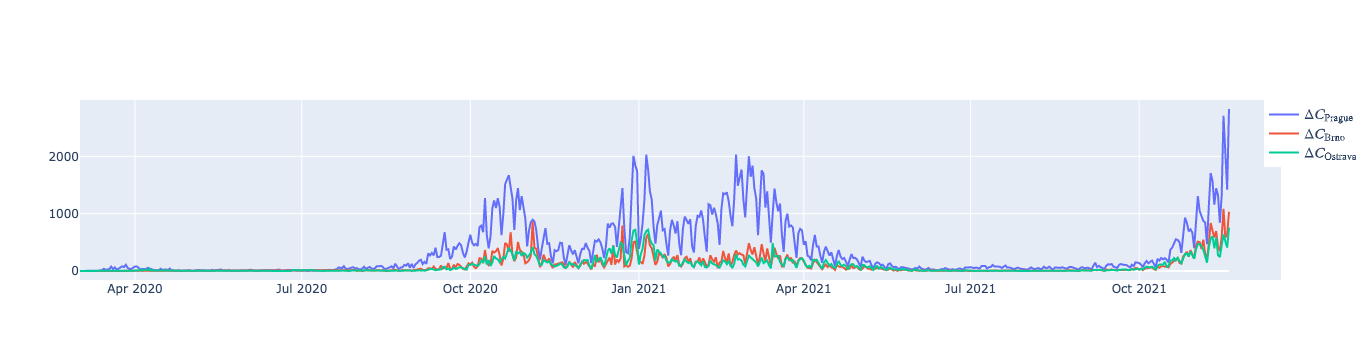

In [36]:
prague_data = data_manager[PRAGUE_CODE]
brno_data = data_manager[BRNO_CODE]
ostrava_data = data_manager[OSTRAVA_CODE]

class LargestCitiesIncidenceFigure(PlotlyFigure):
    def __init__(self):
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=prague_data.dates, y=prague_data.obs_ΔC, name=r"$\Delta C_{\text{Prague}}$"))
        fig.add_trace(go.Scatter(x=brno_data.dates, y=brno_data.obs_ΔC, name=r"$\Delta C_{\text{Brno}}$"))
        fig.add_trace(go.Scatter(x=ostrava_data.dates, y=ostrava_data.obs_ΔC, name=r"$\Delta C_{\text{Ostrava}}$"))

        super().__init__(fig)

LargestCitiesIncidenceFigure().save("largest-cities-incidence").show()

In [103]:
class LatexTable:
    def __init__(self, table_name, caption, columns: List[str], no_header = False):
        self._table_name = table_name
        self._caption = caption
        self._columns = columns
        self._no_header = no_header
        self._rows = []
        self._code = None

    def add_row(self, entry: List[str]):
        assert len(entry) == len(self._columns)

        self._rows.append(entry)

    @property
    def code(self) -> str:
        if self._code is None:
            self._code = r"\begin{table}" + "\n"
            self._code += r"\begin{tabularx}{\textwidth}{lllX}" + "\n"
            self._code += r"\toprule" + "\n"

            if not self._no_header:
                self._code += " & ".join(self._columns) + r" \\" + "\n"

            self._code += r"\midrule" + "\n"
            
            for row in self._rows:
                self._code += " & ".join(row) + r" \\" + "\n"

            self._code += r"\bottomrule" + "\n"
            self._code += r"\end{tabularx}" + "\n"

            self._code += r"\caption{" + self._caption + r"}" + "\n"
            self._code += r"\label{tab:" + self._table_name + r"}" + "\n"
            self._code += r"\end{table}" + "\n"

        return self._code

    def show(self) -> LatexTable:
        print(self.code)

        return self

    def save(self) -> LatexTable:
        with open("tables/{}.tex".format(self._table_name),"w+") as fp:
            fp.write(self.code)

        return self

In [104]:
def adf_test(data, table_name, caption):
    table = LatexTable(table_name=table_name, caption=caption, columns=["", ""], no_header=True)
    result = adfuller(data)
    # print('ADF Statistic: %f' % result[0])
    # print('p-value: %f' % result[1])
    # print('Critical Values:')
    table.add_row(["ADF Statistic", "%.3f" % result[0]])
    table.add_row(["p-value", "%.3f" % result[1]])
    table.add_row(["Critical Values", ""])

    for key, value in result[4].items():
        table.add_row(["", '%s: %.3f' % (key.replace("%", "\%"), value)])
        # print('\t%s: %.3f' % (key, value))
        
    return table

adf_test(prague_data.obs_ΔC, "adf_test_prague", "ADF stationary test for Prague incidence data").show().save()

\begin{table}
\begin{tabularx}{\textwidth}{lllX}
\toprule
\midrule
ADF Statistic & -1.245 \\
p-value & 0.654 \\
Critical Values &  \\
 & 1\%: -3.441 \\
 & 5\%: -2.866 \\
 & 10\%: -2.569 \\
\bottomrule
\end{tabularx}
\caption{ADF stationary test for Prague incidence data}
\label{tab:adf_test_prague}
\end{table}



In [39]:
adf_test(brno_data.obs_ΔC)
adf_test(ostrava_data.obs_ΔC)

ADF Statistic: -0.786841
p-value: 0.822957
Critical Values:
	1%: -3.441
	5%: -2.866
	10%: -2.569
ADF Statistic: -1.237404
p-value: 0.657302
Critical Values:
	1%: -3.441
	5%: -2.866
	10%: -2.569


In [40]:
class SeasonalDecompositionFigure(PlotlyFigure):
    def __init__(self, x, data, model: str):
        # add 1 to avoid zero division in multiplicative model
        res = seasonal_decompose(data + 1, model=model, period=7)

        fig = make_subplots(rows=3, cols=1)

        fig.add_trace(go.Scatter(x=x, y=data, name=r"$\Delta C$"), col=1, row=1)
        fig.add_trace(go.Scatter(x=x, y=res.trend, name=r"$T$"), col=1, row=1)
        fig.add_trace(go.Scatter(x=x, y=res.seasonal, name=r"$S$"), col=1, row=2)
        fig.add_trace(go.Scatter(x=x, y=res.resid, name=r"$\epsilon$"), col=1, row=3)

        super().__init__(fig)

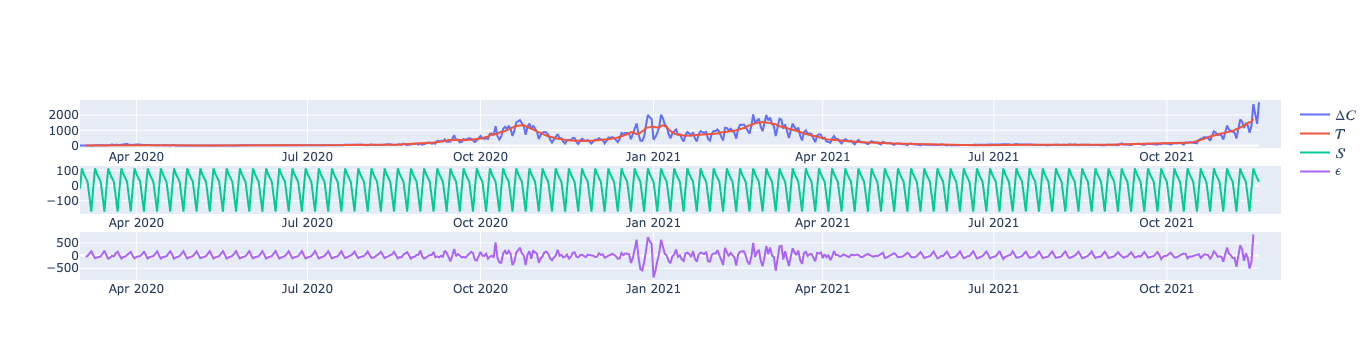

In [41]:
SeasonalDecompositionFigure(prague_data.dates, prague_data.obs_ΔC, "additive").save("seasonal-decomposition-additive").show()

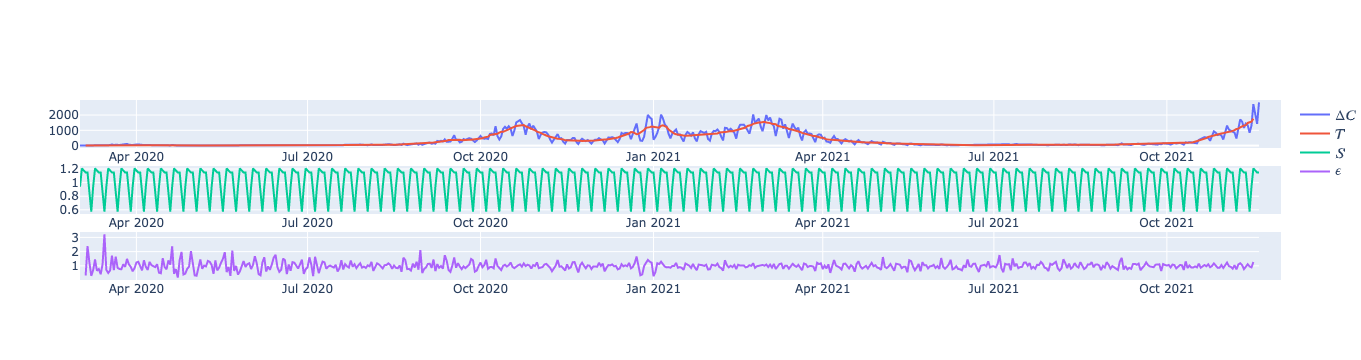

In [42]:
SeasonalDecompositionFigure(prague_data.dates, prague_data.obs_ΔC, "multiplicative").save("seasonal-decomposition-multiplicative").show()

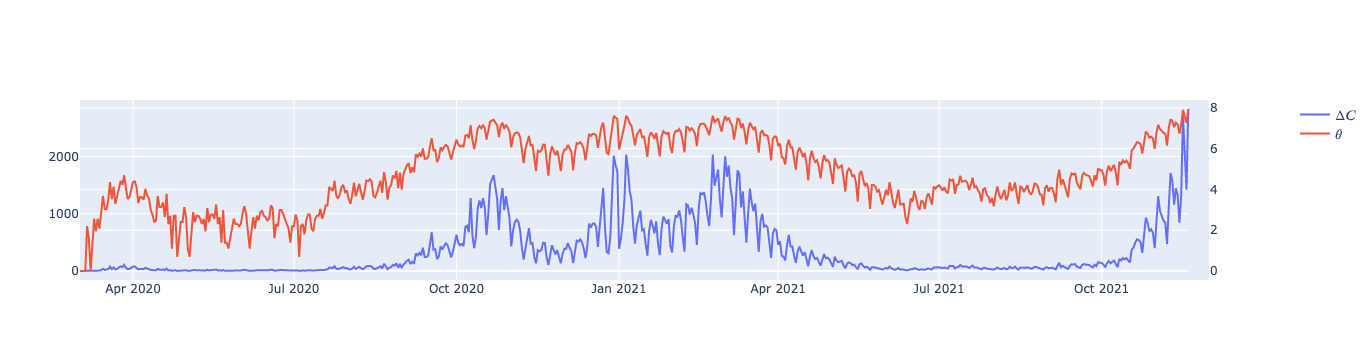

In [43]:
class IncidenceLogTransformFigure(PlotlyFigure):
    def __init__(self):
        fig = make_subplots(specs=[[{"secondary_y": True}]])
        fig.add_trace(go.Scatter(x=prague_data.dates, y=prague_data.obs_ΔC, name=r"$\Delta C$"), secondary_y=False)
        fig.add_trace(go.Scatter(x=prague_data.dates, y=np.log(prague_data.obs_ΔC + 1), name=r"$\theta$"), secondary_y=True)

        super().__init__(fig)

IncidenceLogTransformFigure().save("incidence-log-transform").show()

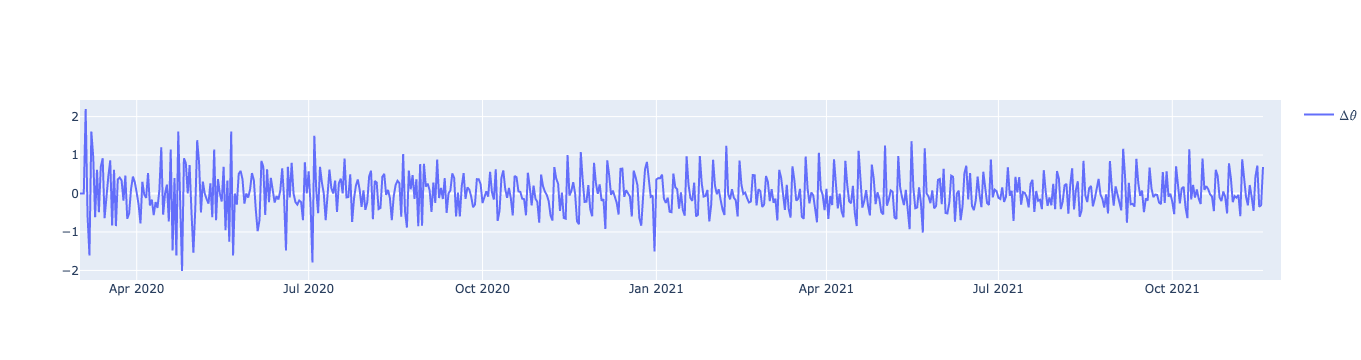

In [44]:
# add +1 to avoid log of zero
theta = np.log(prague_data.obs_ΔC + 1)
theta_diff = np.diff(theta)

class ThetaDiffFigure(PlotlyFigure):
    def __init__(self):
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=prague_data.dates, y=theta_diff, name=r"$\Delta \theta$"))
        fig.update_layout(showlegend=True)

        super().__init__(fig)

ThetaDiffFigure().save("theta-diff-figure").show()

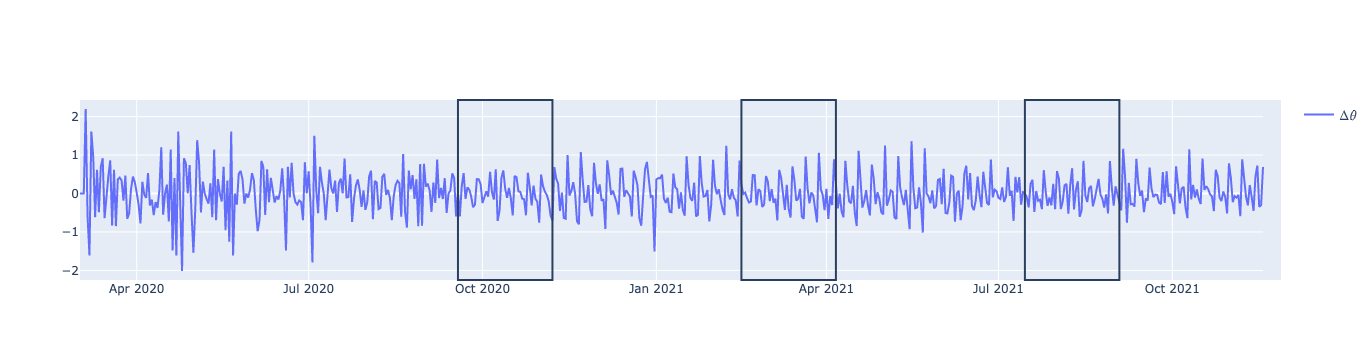

In [45]:
window_size = 50
# prague_theta_sample_start1 = 200
# prague_theta_sample_start2 = 350
# prague_theta_sample_start3 = 500

theta_sample_start_indexes = [200, 350, 500]

class ThetaSampleWindowsFigure(PlotlyFigure):
    def __init__(self):
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=prague_data.dates, y=theta_diff, name=r"$\Delta \theta$"))
        fig.update_layout(showlegend=True)

        for index in theta_sample_start_indexes:
            fig.add_vrect(
                x0=prague_data.get_date_by_index(index),
                x1=prague_data.get_date_by_index(index + window_size))

        super().__init__(fig)

ThetaSampleWindowsFigure().save("theta-sample-windows").show()

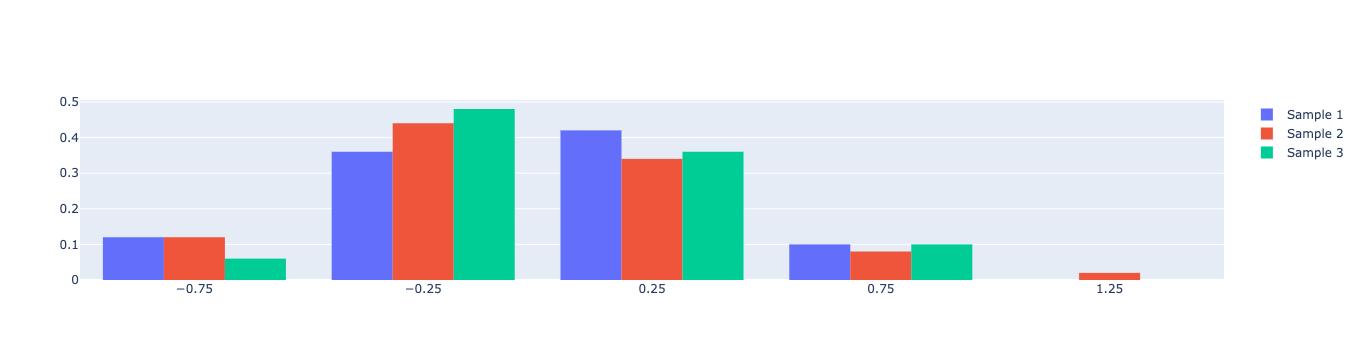

In [46]:
theta_diff_samples = [theta_diff[index:index + window_size] for index in theta_sample_start_indexes]

class ThetaDiffHistogramFigure(PlotlyFigure):
    def __init__(self):
        fig = go.Figure()
        for i, diffs in enumerate(theta_diff_samples, start=1):
            fig.add_trace(go.Histogram(
                x=diffs,
                histnorm="probability",
                xbins=dict(size=0.5),
                name="Sample {}".format(i)))

        super().__init__(fig)

ThetaDiffHistogramFigure().save("theta-diff-histogram").show()

/Users/stepanskovajsa/.local/share/virtualenvs/mthesis-GtPzmeXw/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning:

marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.

/Users/stepanskovajsa/.local/share/virtualenvs/mthesis-GtPzmeXw/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning:

marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.

/Users/stepanskovajsa/.local/share/virtualenvs/mthesis-GtPzmeXw/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning:

marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.



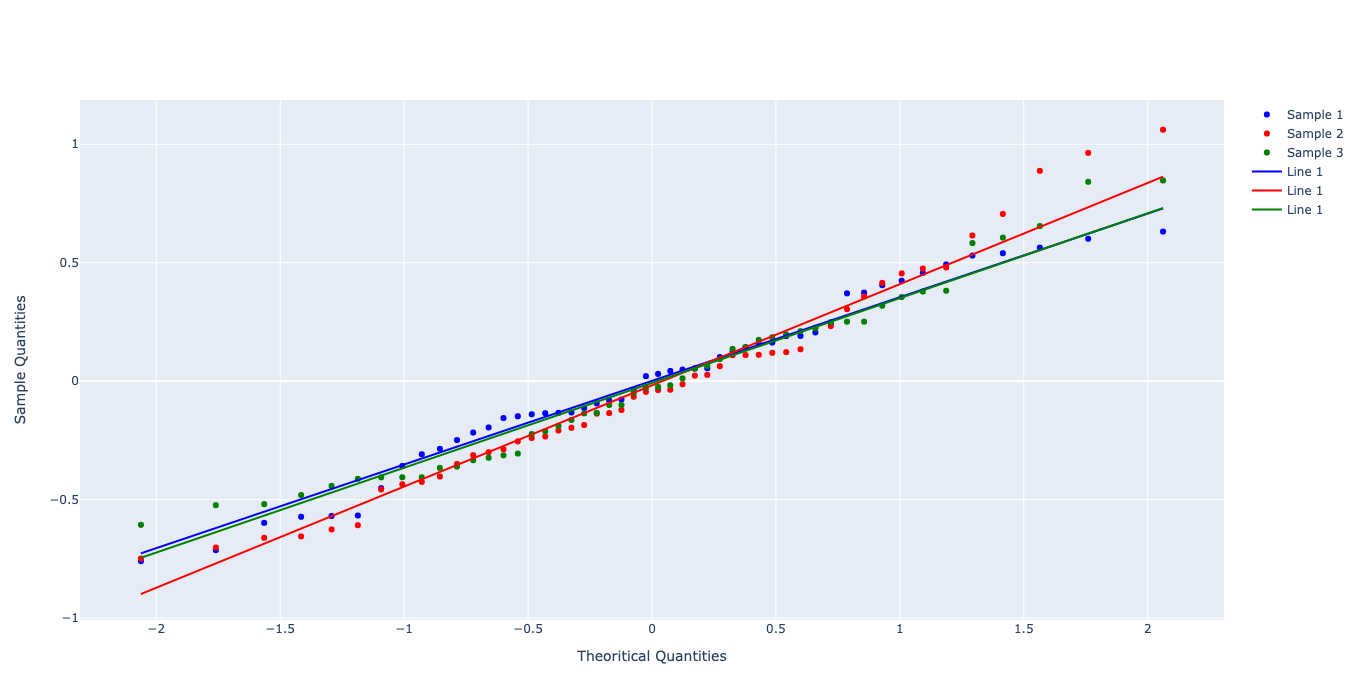

In [49]:
qqplots = []
for diffs in theta_diff_samples:
    entry = qqplot(diffs, line='s').gca().lines
    plt.close()
    qqplots.append(entry)

class ThetaDiffQQFigure(PlotlyFigure):
    def __init__(self, colors=["blue", "red", "green"]):
        fig = go.Figure()

        for i, (qqplot, color) in enumerate(zip(qqplots, colors), start=1):
            fig.add_trace({
                'type': 'scatter',
                'x': qqplot[0].get_xdata(),
                'y': qqplot[0].get_ydata(),
                'mode': 'markers',
                'name': 'Sample {}'.format(i),
                'marker': {
                    'color': color
                }
            })

        for i, (qqplot, color) in enumerate(zip(qqplots, colors), start=1):
            fig.add_trace({
                'type': 'scatter',
                'x': qqplot[1].get_xdata(),
                'y': qqplot[1].get_ydata(),
                'mode': 'lines',
                'name': 'Line 1',
                'line': {
                    'color': color
                }
            })

        fig['layout'].update({
            # 'title': 'Quantile-Quantile Plot',
            'xaxis': {
                'title': 'Theoritical Quantities',
                'zeroline': False
            },
            'yaxis': {
                'title': 'Sample Quantities'
            },
            'width': 800,
            'height': 700,
        })

        super().__init__(fig)

ThetaDiffQQFigure().save("theta-diff-qq").show()

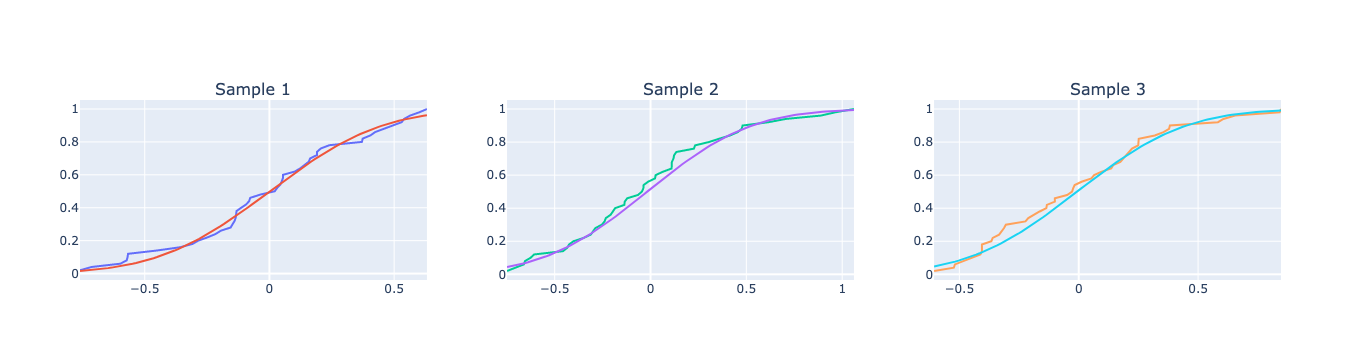

In [50]:
class ThetaDiffECDF(PlotlyFigure):
    def __init__(self):
        titles = ["Sample {}".format(i + 1) for i in range(len(theta_diff_samples))]
        fig = make_subplots(rows=1, cols=3, subplot_titles=titles)

        for col, sample in enumerate(theta_diff_samples, start=1):
            xx = np.linspace(np.min(sample), np.max(sample), 100)
            m = sample.mean()
            sd = sample.std()

            pt_sorted = np.sort(sample)

            ys = np.arange(1, len(pt_sorted)+1)/float(len(pt_sorted))
            fig.add_trace(go.Scatter(x=pt_sorted, y=ys), row=1, col=col)
            fig.add_trace(go.Scatter(x=xx, y=st.norm(m, sd).cdf(xx)), row=1, col=col)

        fig.update_layout(showlegend=False)

        super().__init__(fig)

ThetaDiffECDF().save("theta-diff-ecdf").show()

In [51]:
for i, sample in enumerate(theta_diff_samples, start=1):
    print("Sample {}:".format(i), st.kstest(sample, 'norm'))

Sample 1: KstestResult(statistic=0.2638391209978126, pvalue=0.0014634033316931472)
Sample 2: KstestResult(statistic=0.22704962273087637, pvalue=0.009536491995049579)
Sample 3: KstestResult(statistic=0.280400791169223, pvalue=0.0005714394096856257)


In [52]:
for i, sample in enumerate(theta_diff_samples, start=1):
    print("Sample {}:".format(i), lilliefors(sample, dist='norm', pvalmethod='approx'))

Sample 1: (0.06991110929951821, 0.777705813367911)
Sample 2: (0.10216665768132682, 0.21760669404871025)
Sample 3: (0.0952632144380039, 0.3098471634008525)


In [53]:
# Shapiro-Wilk test for normality
for i, sample in enumerate(theta_diff_samples, start=1):
    print("Sample {}:".format(i), st.shapiro(sample))

Sample 1: ShapiroResult(statistic=0.973589301109314, pvalue=0.32192397117614746)
Sample 2: ShapiroResult(statistic=0.9689982533454895, pvalue=0.2106604129076004)
Sample 3: ShapiroResult(statistic=0.9630106687545776, pvalue=0.11885590106248856)


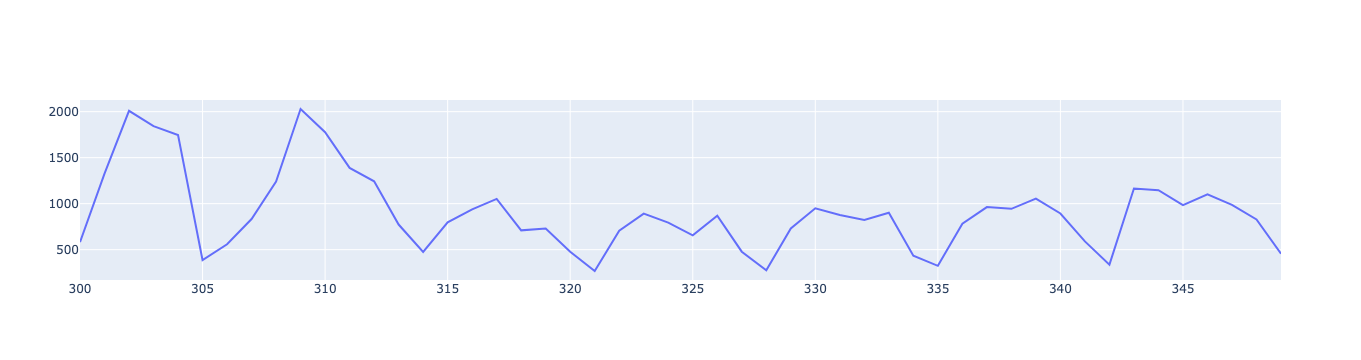

In [54]:
start_index = 300
end_index = start_index + window_size

example_incidence = prague_data.obs_ΔC[start_index:end_index]

class DevIncidenceFigure(PlotlyFigure):
    def __init__(self):
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=np.arange(start_index, end_index), y=example_incidence))

        super().__init__(fig)

DevIncidenceFigure().save("dev-incidence").show()

In [56]:
def build_model(incidence_data, lengthscale=5.0, eta=1.0):
    with pm.Model() as model:
        b = pm.Normal("b", mu=2.0, sigma=1.0)
        a = pm.Normal("a", mu=0.0, sigma=0.5)
        alpha = pm.Exponential("alpha", 2.0)

        mean_func = pm.gp.mean.Linear(coeffs=a, intercept=b)
        cov_func = eta ** 2 * pm.gp.cov.ExpQuad(1, ls=lengthscale)

        gp = pm.gp.Latent(mean_func=mean_func, cov_func=cov_func)
        theta = gp.prior("theta", X=np.arange(0, len(incidence_data))[:, None])

        # incidence = pm.Poisson("incidence", mu=tt.clip(tt.exp(theta), 0, np.inf), observed=incidence_data)
        # incidence = pm.NegativeBinomial("incidence", mu=tt.clip(tt.exp(theta), 0, np.inf), alpha=alpha, observed=incidence_data)
        incidence = pm.NegativeBinomial("incidence", mu=tt.exp(theta), alpha=alpha, observed=incidence_data)

        return model

model = build_model(example_incidence)

In [57]:
pm.model_to_graphviz(model)

ImportError: This function requires the python library graphviz, along with binaries. The easiest way to install all of this is by running

	conda install -c conda-forge python-graphviz

In [58]:
def sample_model(model):
    with model:
        return pm.sample(1000, tune=2000, return_inferencedata=True)

trace = sample_model(model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta_rotated_, alpha, a, b]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 35 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.


array([[<AxesSubplot:title={'center':'theta'}>,
        <AxesSubplot:title={'center':'theta'}>],
       [<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'b'}>,
        <AxesSubplot:title={'center':'b'}>],
       [<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>]], dtype=object)

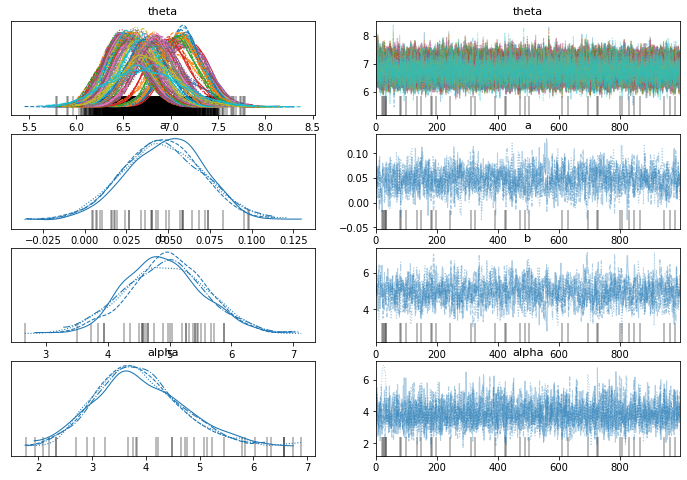

In [59]:
az.plot_trace(trace, var_names=["theta", "a", "b", "alpha"])

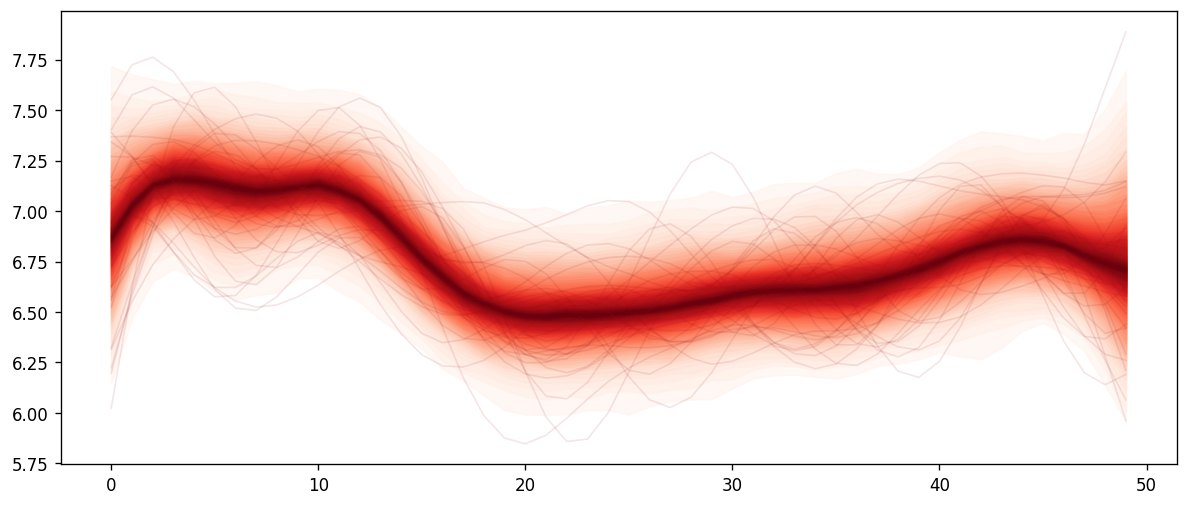

In [60]:
from pymc3.gp.util import plot_gp_dist

fig = plt.figure(figsize=(12, 5), dpi=120)
ax = fig.gca()
plot_gp_dist(ax, trace.posterior["theta"][0, :, :], np.arange(window_size))
plt.show()

In [61]:
def make_posterior_predictive(model, trace):
    with model:
        return pm.sample_posterior_predictive(
            trace.posterior, var_names=["incidence", "theta", "a", "b"])

ppc = make_posterior_predictive(model, trace)

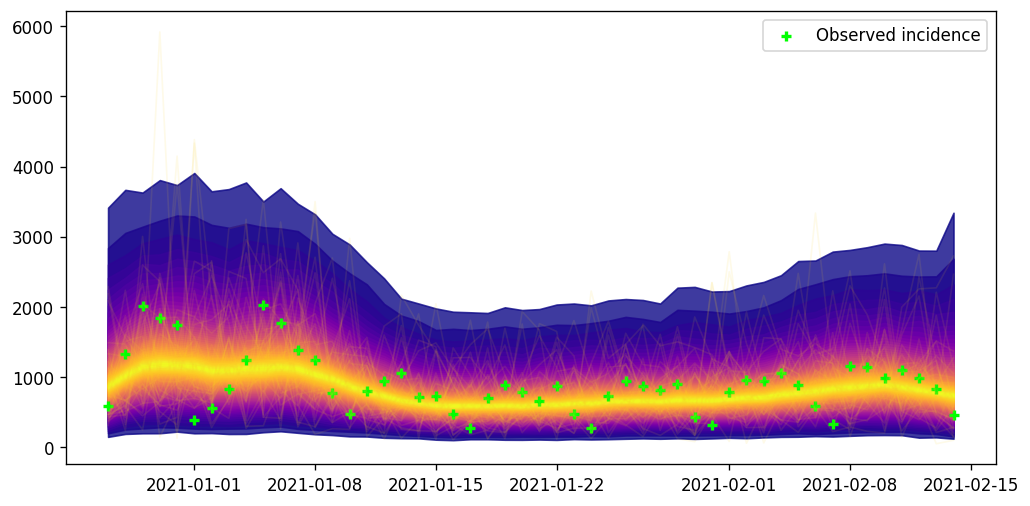

In [62]:
xx_dates = prague_data.dates[start_index:end_index]
incidence_mat = ppc["incidence"]

def plot_posterior(xx, incidence_matrix, observed_incidence):
    fig = plt.figure(figsize=(10, 5), dpi=120)
    ax = fig.gca()
    plot_gp_dist(ax=ax, samples=incidence_matrix, x=xx, palette="plasma")
    ax.scatter(x=xx, y=observed_incidence, color="lime", marker="+", lw=2, label="Observed incidence")
    plt.legend()
    # plt.savefig('books_read.png')
    plt.show()

plot_posterior(xx_dates, incidence_mat, example_incidence)

In [65]:
def make_prevalence_matrix(A, si_weights):
    si_len = len(si_weights)
    C = np.zeros((A.shape[0], A.shape[1] - si_len))

    for t in range(si_len, A.shape[1]):
        C[:, t - si_len] = np.sum(A[:, t - si_len:t] * np.flip(si_weights), axis=1)

    return C

si_weights = nishiura_si.as_weights(tau_m)
xx_dates_epi = xx_dates[len(si_weights):]
prevalence_mat = make_prevalence_matrix(incidence_mat, si_weights)

In [66]:
def get_quantile_traces(xx, values, title, quantiles=[0.75, 0.95]):
    median = np.median(values, axis=1)
    traces = []
  
    for quantile in quantiles:
        a = (1 - quantile) / 2
        y_upper = np.quantile(values, q=1 - a, axis=1)
        y_lower = np.quantile(values, q=a, axis=1)

        traces.extend([
            go.Scatter(
                name="{:.0%} CI".format(quantile),
                x=xx,
                y=y_upper,
                mode='lines',
                line=dict(width=0),
                showlegend=True
            ),
            go.Scatter(
                x=xx,
                y=y_lower,
                # marker=dict(color="#444"),
                marker=dict(opacity=0.7),
                line=dict(width=0),
                mode='lines',
                # fillcolor='rgba(68, 68, 68, 0.3)',
                fill='tonexty',
                showlegend=False
            )
        ])

    traces.append(go.Scatter(
        name=title,
        x=xx,
        y=median,
        mode='lines',
    ))

    return traces

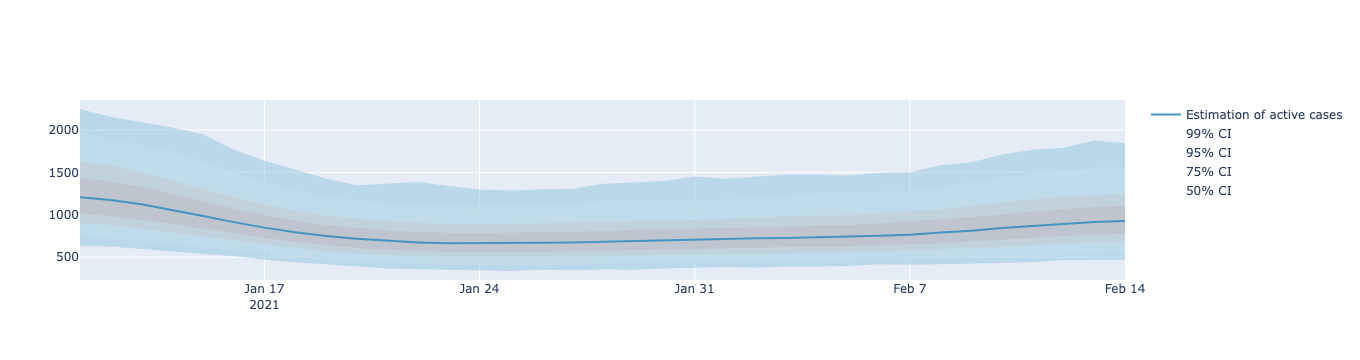

In [67]:
def plot_active_cases_estimation(xx, prevalence_matrix):
    layout = go.Layout(colorway=px.colors.sequential.RdBu)
    fig = go.Figure([
        *get_quantile_traces(
            xx,
            prevalence_matrix.T,
            quantiles=[0.5, 0.75, 0.95, 0.99],
            title="Estimation of active cases")
    ], layout=layout)

    fig.show()

plot_active_cases_estimation(xx_dates_epi, prevalence_mat)

In [68]:
Rt = incidence_mat[:, len(si_weights):] / prevalence_mat[:, :]

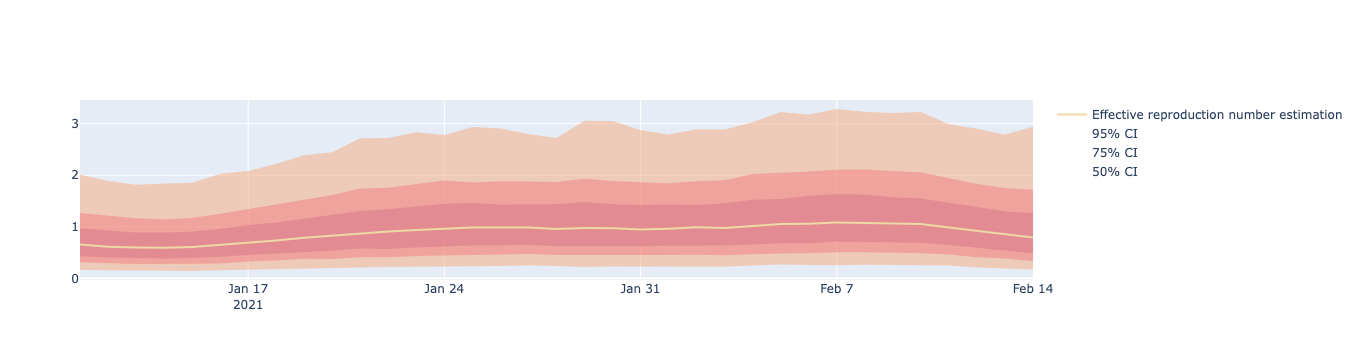

In [69]:
def plot_reproduction_number(xx, R_matrix):
    layout = go.Layout(colorway=px.colors.sequential.Agsunset)
    fig = go.Figure([
        *get_quantile_traces(
            xx,
            R_matrix.T,
            quantiles=[0.5, 0.75, 0.95],
            title="Effective reproduction number estimation")
    ], layout=layout)

    fig.show()

plot_reproduction_number(xx_dates_epi, Rt)

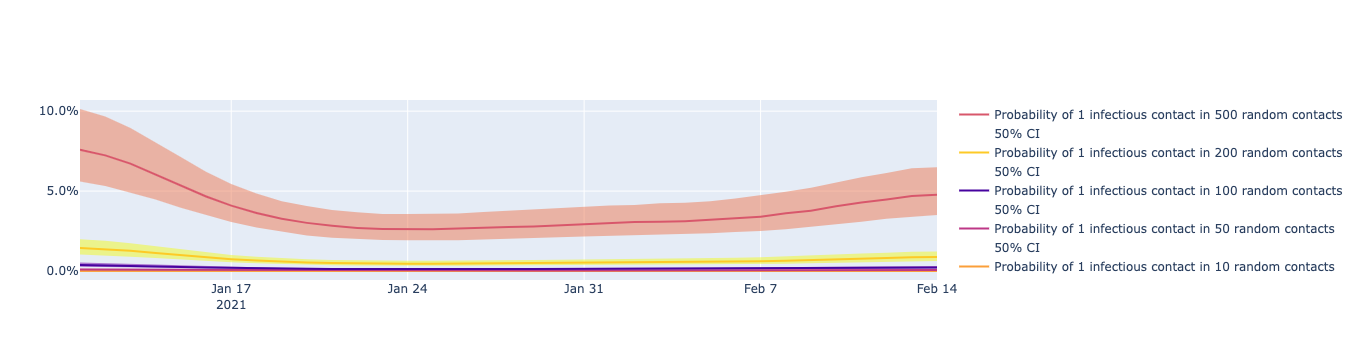

In [70]:
def plot_infected_contact_prob(xx, prevalence_matrix, pop_size, contact_counts=[10, 50, 100, 200, 500]):
    prob_matrices = [
        1 - st.hypergeom(M=pop_size, n=prevalence_matrix, N=N).cdf(1)
        for N in contact_counts]

    layout = go.Layout(yaxis=dict(tickformat=".1%"), colorway=px.colors.sequential.Plasma_r)
    fig = go.Figure(layout=layout)

    for prob_matrix, N in zip(prob_matrices, contact_counts):
        fig.add_traces(get_quantile_traces(
            xx,
            prob_matrix.T,
            title='Probability of 1 infectious contact in {} random contacts'.format(N),
            quantiles=[0.5]))

    fig.show()

plot_infected_contact_prob(xx_dates_epi, prevalence_mat, prague_data.N)

In [71]:
si_weights = nishiura_si.as_weights(tau_m)
si_days = np.arange(tau_m)
si_exp_val = si_weights.dot(si_days)
si_exp_val


4.542764509386419

In [72]:
gamma = 1 / si_exp_val
gamma

0.22013027484338335

Discretized eqs:

\begin{equation}
incidence = \beta_t I_{t-1} \frac{S_{t-1}}{N}
\end{equation}

\begin{equation}
\mathcal{R}_0 = \frac{\beta_t}{\gamma_t}
\end{equation}

\begin{equation}
\mathcal{R}_t = \mathcal{R}_0 \frac{S_{t-1}}{N} = \frac{\beta_t}{\gamma_t} \frac{S_{t-1}}{N}
\end{equation}

To express $\beta_t$:
\begin{equation}
\beta_t = \frac{\gamma_t N \mathcal{R}_t}{S_{t-1}}
\end{equation}

Putting into incidence eq:
\begin{equation}
incidence = \gamma_t \mathcal{R}_t I_{t-1}
\end{equation}

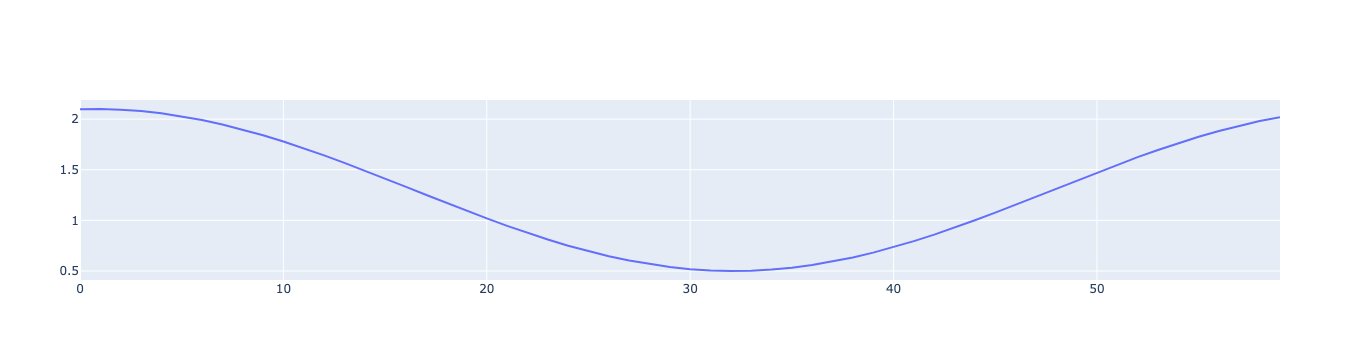

In [73]:
test_days = np.arange(60)
Rt_ts = 1.3 + 0.8 * np.sin(1.5 + 0.1 * test_days)

fig = go.Figure()
fig.add_trace(go.Scatter(x=test_days, y=Rt_ts, name=r"$\mathcal{R}_t$"))
fig.show()

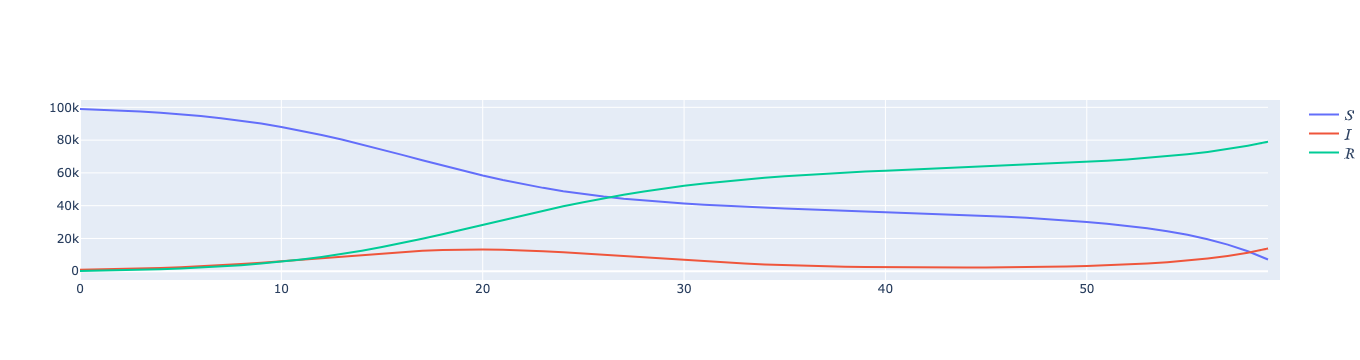

In [75]:
N = 100000
I = 700
S = N - I
R = 0

tss = []

for i in test_days:
    true_inc = int(I * gamma * Rt_ts[i])
    restored = int(I * gamma)

    S -= true_inc
    I += true_inc - restored
    R += restored

    m = true_inc
    sigma = 0.5 * true_inc
    obs_inc = st.nbinom(m ** 2 / (sigma ** 2 - m), m / (sigma ** 2)).rvs()
    tss.append((S, I, R, true_inc, obs_inc))

S, I, R, true_inc, obs_inc = zip(*tss)

fig = go.Figure()
fig.add_trace(go.Scatter(x=test_days, y=S, name=r"$S$"))
fig.add_trace(go.Scatter(x=test_days, y=I, name=r"$I$"))
fig.add_trace(go.Scatter(x=test_days, y=R, name=r"$R$"))
fig.show()

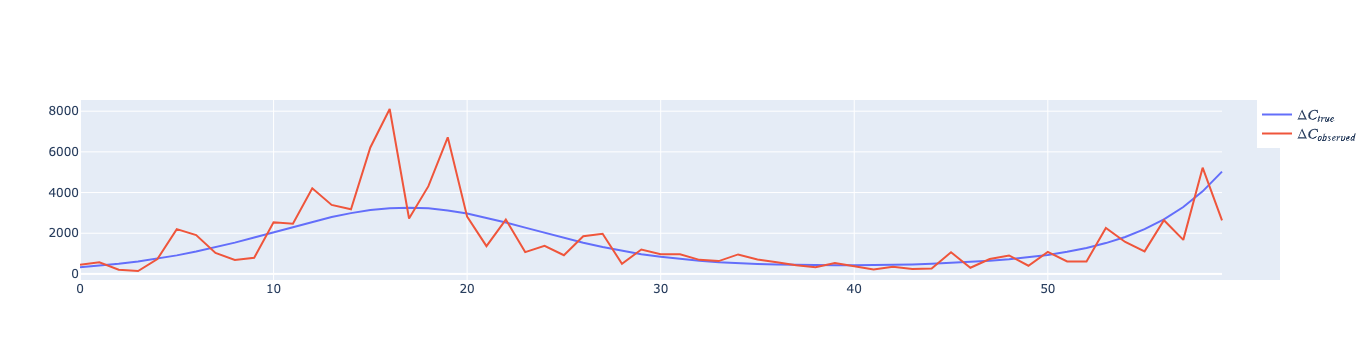

In [76]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_days, y=true_inc, name=r"$\Delta C_{true}$"))
fig.add_trace(go.Scatter(x=test_days, y=obs_inc, name=r"$\Delta C_{observed}$"))
fig.show()

In [77]:
model = build_model(obs_inc[:window_size])
trace = sample_model(model)
ppc = make_posterior_predictive(model, trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta_rotated_, alpha, a, b]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 25 seconds.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 67 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


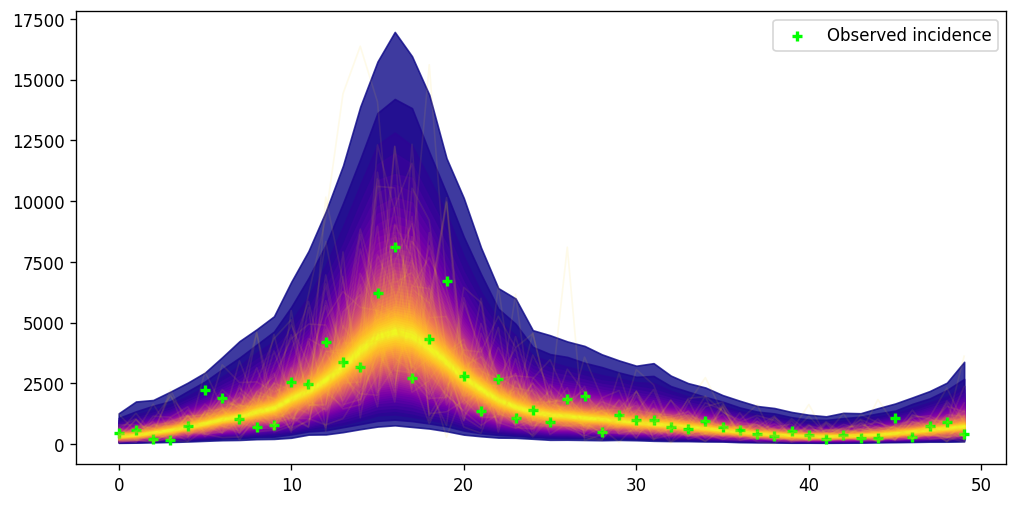

In [78]:
incidence_mat = ppc["incidence"]
plot_posterior(np.arange(window_size), incidence_mat, obs_inc[:window_size])

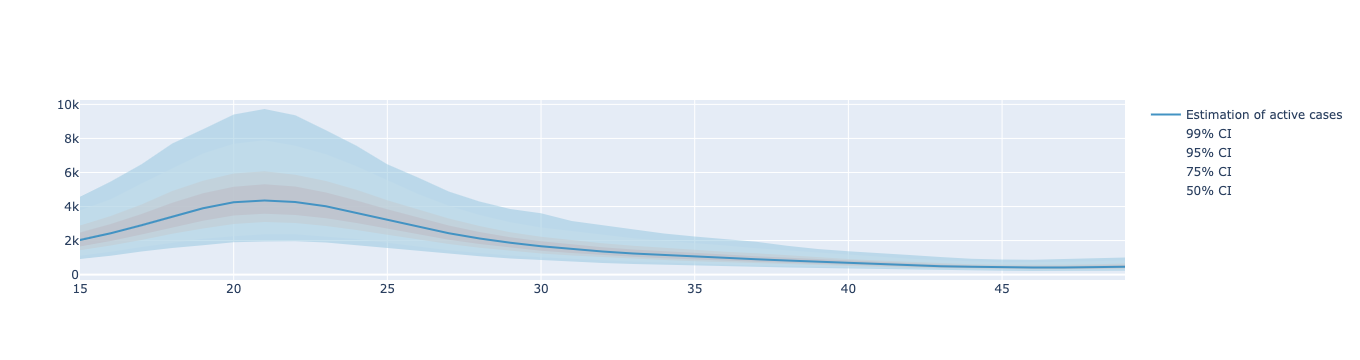

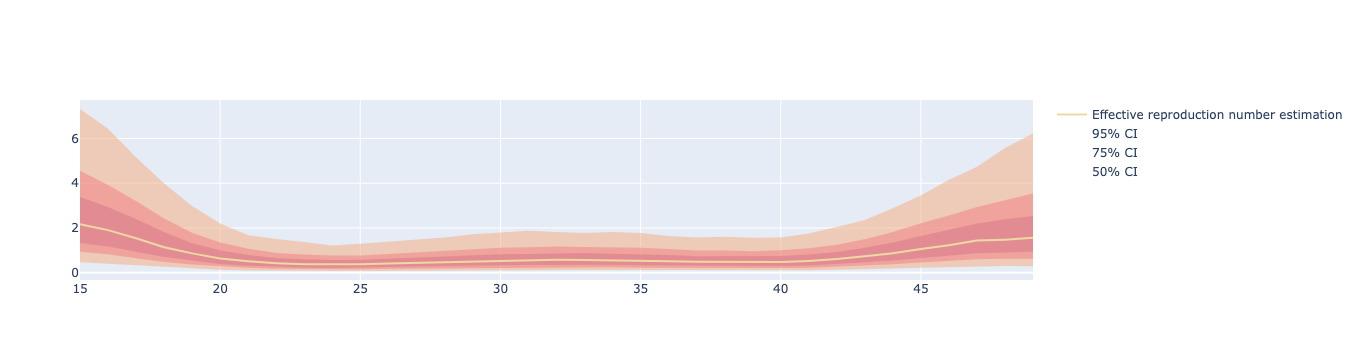

In [79]:
prevalence_mat = make_prevalence_matrix(incidence_mat, si_weights)
Rt = incidence_mat[:, len(si_weights):] / prevalence_mat[:, :]

xx_dates_epi = np.arange(len(si_weights), window_size)
plot_active_cases_estimation(xx_dates_epi, prevalence_mat)
plot_reproduction_number(xx_dates_epi, Rt)

----

Not developed yet

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta_rotated_, alpha, a, b]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 49 seconds.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.


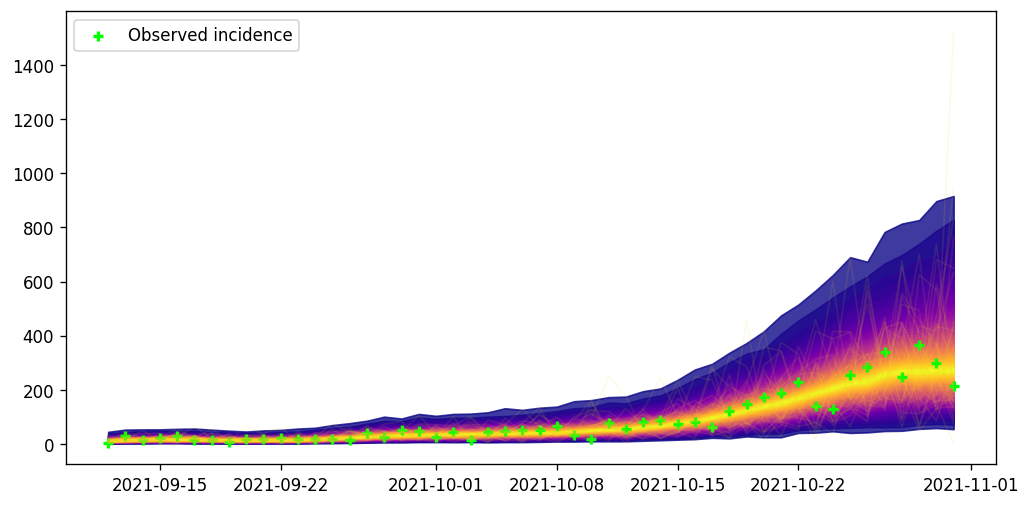

In [ ]:
class EpidemicEstimator:
    def __init__(self, nuts_code, serial_interval: SerialInterval, si_len, window_size):
        self.si_len = si_len
        self.si_weights = serial_interval.as_weights(si_len)
        self.window_size = window_size
        self.data = data_manager[nuts_code]

    def estimate(self, to_date: str):
        end_index = self.data.get_index_by_date(to_date)
        start_index = end_index - self.window_size
        xx_dates = self.data.dates[start_index:end_index]

        observed_incidence = self.data.obs_ΔC[start_index:end_index]
        model = build_model(observed_incidence)
        trace = sample_model(model)
        ppc = make_posterior_predictive(model, trace)
        incidence_mat = ppc["incidence"]
        plot_posterior(xx_dates, incidence_mat, observed_incidence)

        prevalence_mat = make_prevalence_matrix(incidence_mat, self.si_weights)
        Rt = incidence_mat[:, len(self.si_weights):] / prevalence_mat[:, :]

        xx_dates_epi = xx_dates[len(self.si_weights):]
        plot_active_cases_estimation(xx_dates_epi, prevalence_mat)
        plot_reproduction_number(xx_dates_epi, Rt)
        plot_infected_contact_prob(xx_dates_epi, prevalence_mat, self.data.N)

estimator = EpidemicEstimator(nuts_code=BRNO_CODE, serial_interval=nishiura_si, si_len=tau_m, window_size=window_size)
estimator.estimate("2021-11-1")